<a href="https://colab.research.google.com/github/Krish6115/NNDL_PROJ/blob/main/Efficientb1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
vipoooool_new_plant_diseases_dataset_path = kagglehub.dataset_download('vipoooool/new-plant-diseases-dataset')

print('Data source import complete.')


2025-10-16 16:20:52.544830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760631652.943957      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760631653.076314      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


--- Setting up Train/Validation/Test datasets for Apple ---
Dataset setup complete. Using data from: /kaggle/working/apple_dataset
--------------------------------------------------
Found 7771 files belonging to 4 classes.


I0000 00:00:1760631677.025511      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760631677.026218      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 1943 files belonging to 4 classes.
Found 2 files belonging to 2 classes.
Found 4 classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Training Baseline Model (LR=0.001) ---
Epoch 1/25


E0000 00:00:1760631695.503305      37 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/EfficientNetB0_Transfer_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1760631698.050349     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


243/243 ━━━━━━━━━━━━━━━━━━━━ 48s 124ms/step - accuracy: 0.7471 - loss: 0.7022 - val_accuracy: 0.9449 - val_loss: 0.2170
Epoch 2/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.9449 - loss: 0.1962 - val_accuracy: 0.9619 - val_loss: 0.1337
Epoch 3/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.9643 - loss: 0.1348 - val_accuracy: 0.9707 - val_loss: 0.1013
Epoch 4/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.9700 - loss: 0.1071 - val_accuracy: 0.9732 - val_loss: 0.0871
Epoch 5/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.9807 - loss: 0.0808 - val_accuracy: 0.9738 - val_loss: 0.0747
Epoch 6/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9760 - loss: 0.0822 - val_accuracy: 0.9815 - val_loss: 0.0625
Epoch 7/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9798 - loss: 0.0719 - val_accuracy: 0.9840 - val_loss: 0.0578
Epoch 8/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.9816 - loss: 0.0672 - val_accura

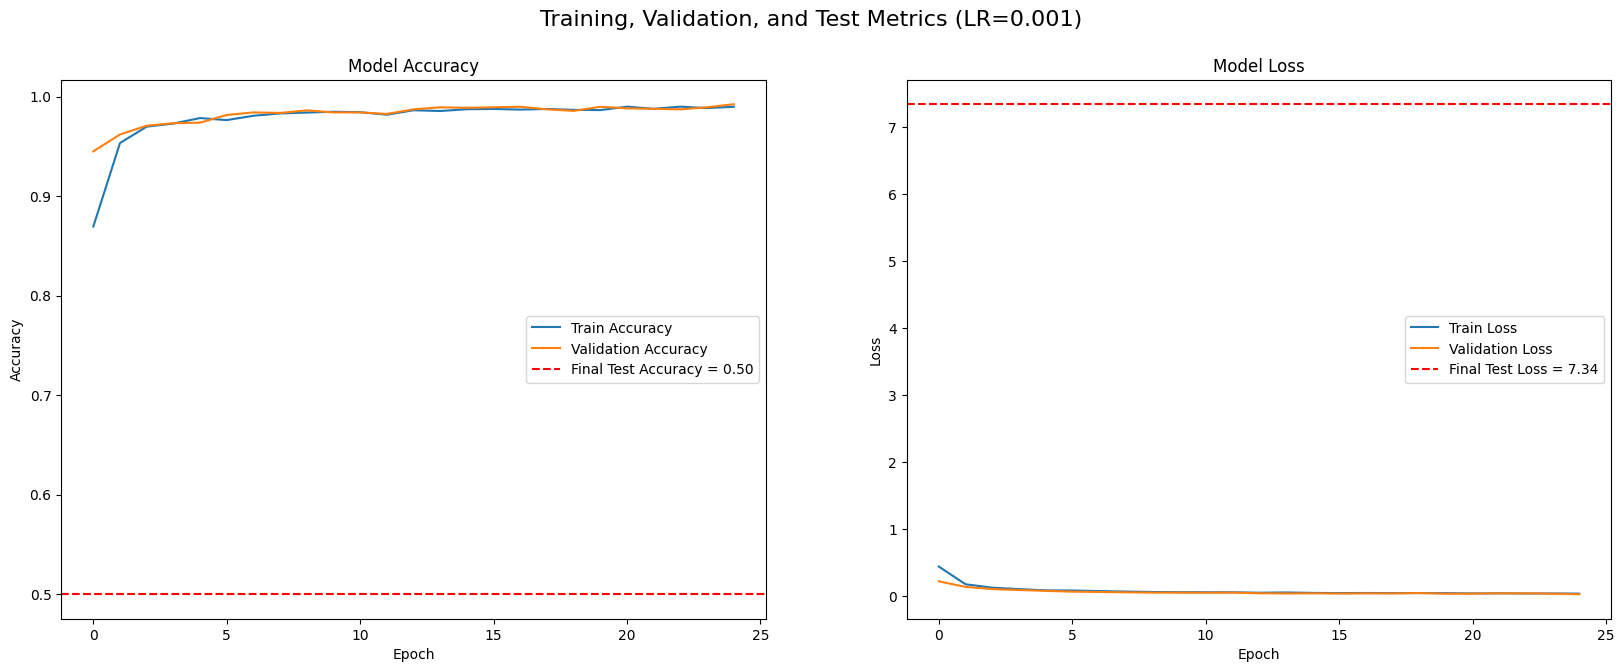

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

# 1. SETUP: CREATE FOCUSED "APPLE-ONLY" DATASETS
# =============================================================
print("--- Setting up Train/Validation/Test datasets for Apple ---")

# --- Part A: Setup Train and Validation Directories (using symlinks) ---
original_base_train_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
original_base_valid_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
apple_classes = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']

temp_base_dir = '/kaggle/working/apple_dataset'
train_dir = os.path.join(temp_base_dir, 'train')
validation_dir = os.path.join(temp_base_dir, 'valid')

for d in [train_dir, validation_dir]:
    os.makedirs(d, exist_ok=True)

for class_name in apple_classes:
    for original_dir, new_dir in [(original_base_train_dir, train_dir), (original_base_valid_dir, validation_dir)]:
        original_path = os.path.join(original_dir, class_name)
        new_path = os.path.join(new_dir, class_name)
        if not os.path.exists(new_path):
            os.symlink(original_path, new_path)

# --- Part B: Setup Test Directory (copying specific files) ---
original_test_dir = '/kaggle/input/new-plant-diseases-dataset/test/test/'
test_dir = os.path.join(temp_base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

test_files = {
    'Apple___Cedar_apple_rust': 'AppleCedarRust1.JPG',
    'Apple___Apple_scab': 'AppleScab1.JPG'
}

for class_name, filename in test_files.items():
    class_path = os.path.join(test_dir, class_name)
    os.makedirs(class_path, exist_ok=True)
    shutil.copy(os.path.join(original_test_dir, filename), os.path.join(class_path, filename))

print(f"Dataset setup complete. Using data from: {temp_base_dir}")
print("--------------------------------------------------")

# 2. DEFINE CONSTANTS AND HYPERPARAMETERS
# =============================================================
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 0.001 # <-- Baseline Learning Rate

# 3. LOAD ALL THREE DATASETS
# =============================================================
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, shuffle=True, seed=123)
val_ds = tf.keras.utils.image_dataset_from_directory(validation_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, shuffle=False)
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, shuffle=False)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print(f"Found {NUM_CLASSES} classes: {class_names}")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 4. MODEL DEFINITION
# =============================================================
data_augmentation = models.Sequential([layers.RandomFlip("horizontal_and_vertical"), layers.RandomRotation(0.2)], name="data_augmentation")

def build_efficientnet_b0(num_classes, dropout_rate=0.3):
    base_model = applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs, name="EfficientNetB0_Transfer")

# 5. COMPILE AND TRAIN THE MODEL
# =============================================================
model = build_efficientnet_b0(NUM_CLASSES)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print(f"\n--- Training Baseline Model (LR={LEARNING_RATE}) ---")
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[early_stopping])

# 6. EVALUATE ON TRAIN, VALIDATION, AND TEST SETS
# =============================================================
print("\n--- Final Model Performance ---")
train_loss, train_acc = model.evaluate(train_ds, verbose=0)
print(f"Training Accuracy: {train_acc*100:.2f}% | Training Loss: {train_loss:.4f}")

val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"Validation Accuracy: {val_acc*100:.2f}% | Validation Loss: {val_loss:.4f}")

test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}% | Test Loss: {test_loss:.4f}")

# 7. PLOT RESULTS
# =============================================================
def plot_history(history, test_accuracy, test_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    # Plot Accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.axhline(y=test_accuracy, color='r', linestyle='--', label=f'Final Test Accuracy = {test_accuracy:.2f}')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    # Plot Loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.axhline(y=test_loss, color='r', linestyle='--', label=f'Final Test Loss = {test_loss:.2f}')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    plt.suptitle(f'Training, Validation, and Test Metrics (LR={LEARNING_RATE})', fontsize=16)
    plt.show()

plot_history(history, test_acc, test_loss)